![Pytorch](../../../pytorch_logo_2018.svg)

# Pytorch 高级篇（2）：变分自编码器（Variational Auto-Encoder）

>参考代码
>
>**yunjey的 [pytorch tutorial系列](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py)**

## 变分自编码器 学习资料

自编码器有这些个作用，

1. 数据去噪（去噪编码器）
2. 可视化降维
3. 生成数据（与GAN各有千秋）

>**文献**
>
>[Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)

>**讲解视频**
>
>[【深度学习】变分自编码机 Arxiv Insights出品 双语字幕by皮艾诺小叔（非直译）](https://www.bilibili.com/video/av29126924/?spm_id_from=333.788.videocard.0)

>**讲解文章**
>
>[花式解释AutoEncoder与VAE](https://zhuanlan.zhihu.com/p/27549418)
>
>[如何使用变分自编码器VAE生成动漫人物形象](https://www.jiqizhixin.com/articles/generate-anime-character-with-VAE)

## Pytorch 实现

### 预处理

In [4]:
# 包
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [5]:
# 设备配置
torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# 如果没有文件夹就创建一个文件夹
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


In [18]:
# 超参数设置
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

### MINIST 数据集

In [8]:
dataset = torchvision.datasets.MNIST(root='../../../data/minist',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

### 创建VAE模型（变分自编码器（Variational Auto-Encoder））

In [9]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # 保准方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    # 编码过程
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码过程
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    # 整个前向传播过程：编码-》解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [10]:
# 实例化一个模型
model = VAE().to(device)

In [11]:
# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 开始训练

In [19]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # 反向传播和优化
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # 重构的图像
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [100/469], Reconst Loss: 9898.7285, KL Div: 3231.0195
Epoch[1/15], Step [200/469], Reconst Loss: 9985.5391, KL Div: 3290.1267
Epoch[1/15], Step [300/469], Reconst Loss: 9800.6211, KL Div: 3201.4980
Epoch[1/15], Step [400/469], Reconst Loss: 9444.1016, KL Div: 3259.1062
Epoch[2/15], Step [100/469], Reconst Loss: 9204.6201, KL Div: 3056.4475
Epoch[2/15], Step [200/469], Reconst Loss: 9729.0078, KL Div: 3206.0845
Epoch[2/15], Step [300/469], Reconst Loss: 9609.4307, KL Div: 3220.1729
Epoch[2/15], Step [400/469], Reconst Loss: 9514.4150, KL Div: 3206.0166
Epoch[3/15], Step [100/469], Reconst Loss: 9042.1270, KL Div: 3145.2937
Epoch[3/15], Step [200/469], Reconst Loss: 9773.1826, KL Div: 3235.4180
Epoch[3/15], Step [300/469], Reconst Loss: 9427.7207, KL Div: 3141.4922
Epoch[3/15], Step [400/469], Reconst Loss: 9658.2725, KL Div: 3235.2390
Epoch[4/15], Step [100/469], Reconst Loss: 9596.0439, KL Div: 3177.3101
Epoch[4/15], Step [200/469], Reconst Loss: 9158.8330, KL Div: 31

### 结果展示

In [20]:
#导入包
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

#### 重构图

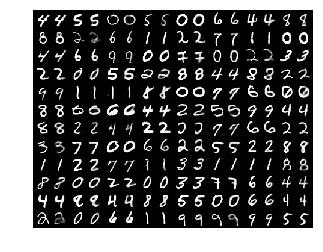

In [21]:
reconsPath = './samples/reconst-55.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

#### 随机生成图

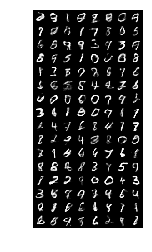

In [22]:
genPath = './samples/sampled-107.png'
Image = mpimg.imread(genPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()